
# STAT 139 Final Homework — Milestone #5 Draft
## Car MSRP Drivers with Linear Models

Paper-structured notebook draft for milestone #5. Sections follow the required paper format and keep methods within the STAT 139 linear-model toolkit.



### Notebook roadmap
- Use the required paper sections: 1) Introduction and Motivation; 2) Data and EDA; 3) Methods; 4) Results; 5) Conclusion and Discussion.
- Clean and explore the Kaggle car MSRP data set used in earlier milestones.
- Fit baseline and extended linear models for log(MSRP), check assumptions with plots, and take remedial steps when diagnostics flag issues (robust SEs, influence trimming).
- Compare OLS and ridge via cross-validation for stability.
- Conclude with interpreted findings and next steps toward the paper.



## 1. Introduction and Motivation
We study how observable car characteristics relate to manufacturer suggested retail price (MSRP). Economic intuition suggests performance (horsepower, cylinders), efficiency (MPG), and brand/segment cues each contribute to price. Understanding their relative magnitudes helps explain price discrimination and consumer segmentation.

Research questions
- How large is the marginal association between horsepower and MSRP once brand and model year are controlled for?
- Are there sizable brand or vehicle-segment premia after performance and efficiency are accounted for?
- Do classical linear-model assumptions (linearity, homoskedastic errors, moderate leverage) look tenable for this application, and how robust are conclusions to influential points?

We analyze `log(MSRP)` to interpret slopes as approximate percent differences and to stabilize variance across a wide price range. The analysis emphasizes interpretability and assumption checks, consistent with the linear-model focus of STAT 139.



## 2. Data and EDA
**Data source.** Kaggle “Car Features and MSRP,” scraped from Edmunds/Twitter; 11,914 rows and 16 columns.

**Planned cleaning.**
- Standardize column names, mark "N/A" and "UNKNOWN" as missing.
- Convert numeric fields; drop rows missing required modeling fields when building the model-ready data.
- Create `log_msrp` for percent-interpretability and variance stabilization.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)
np.random.seed(139)

In [ ]:
# Load and clean
rename_map = {
    "Make": "make",
    "Model": "model",
    "Year": "year",
    "Engine Fuel Type": "engine_fuel",
    "Engine HP": "engine_hp",
    "Engine Cylinders": "engine_cylinders",
    "Transmission Type": "transmission",
    "Driven_Wheels": "driven_wheels",
    "Number of Doors": "num_doors",
    "Market Category": "market_category",
    "Vehicle Size": "vehicle_size",
    "Vehicle Style": "vehicle_style",
    "highway MPG": "highway_mpg",
    "city mpg": "city_mpg",
    "Popularity": "popularity",
    "MSRP": "msrp",
}

raw = pd.read_csv("data.csv")
df = raw.rename(columns=rename_map)

# Flag missing codes
missing_replacements = {
    "market_category": {"N/A": pd.NA},
    "transmission": {"UNKNOWN": pd.NA},
}
df = df.replace(missing_replacements)

# Coerce numeric fields
numeric_cols = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity", "msrp", "num_doors", "year"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Derived response
df["log_msrp"] = np.log(df["msrp"])

print(f"Raw shape: {raw.shape}; cleaned shape (with log_msrp added): {df.shape}")

Raw shape: (11914, 16); cleaned shape (with log_msrp added): (11914, 17)



The dataset retains 11,914 rows after simple cleaning, and `log_msrp` is added for modeling.


In [ ]:
# Variable dictionary for quick reference
variable_info = pd.DataFrame(
    [
        ("make", "categorical", "Manufacturer brand"),
        ("model", "categorical", "Specific model name"),
        ("year", "categorical/int", "Model year"),
        ("engine_fuel", "categorical", "Fuel type"),
        ("engine_hp", "numeric", "Horsepower"),
        ("engine_cylinders", "numeric", "Cylinder count"),
        ("transmission", "categorical", "Transmission type"),
        ("driven_wheels", "categorical", "Drive configuration"),
        ("num_doors", "categorical", "Number of doors"),
        ("market_category", "categorical", "Marketing tags"),
        ("vehicle_size", "categorical", "Size class"),
        ("vehicle_style", "categorical", "Body style"),
        ("highway_mpg", "numeric", "EPA highway MPG"),
        ("city_mpg", "numeric", "EPA city MPG"),
        ("popularity", "numeric", "Popularity index"),
        ("msrp", "numeric", "Manufacturer suggested retail price"),
        ("log_msrp", "numeric", "Log-transformed MSRP"),
    ],
    columns=["variable", "type", "description"],
)
variable_info

,variable,type,description
0,make,categorical,Manufacturer brand
1,model,categorical,Specific model name
2,year,categorical/int,Model year
3,engine_fuel,categorical,Fuel type
4,engine_hp,numeric,Horsepower
5,engine_cylinders,numeric,Cylinder count
6,transmission,categorical,Transmission type
7,driven_wheels,categorical,Drive configuration
8,num_doors,categorical,Number of doors
9,market_category,categorical,Marketing tags



The variable dictionary clarifies which fields are numeric (performance/efficiency) versus categorical (brand, segment, drivetrain), guiding modeling choices and encoding.


In [ ]:
# Missingness snapshot
missing = df.isna().sum().reset_index()
missing.columns = ["variable", "n_missing"]
missing["pct_missing"] = (missing["n_missing"] / len(df) * 100).round(2)
missing.sort_values("pct_missing", ascending=False)

,variable,n_missing,pct_missing
9,market_category,3742,31.41
4,engine_hp,69,0.58
5,engine_cylinders,30,0.25
6,transmission,19,0.16
8,num_doors,6,0.05
3,engine_fuel,3,0.03
11,vehicle_style,0,0.00
15,msrp,0,0.00
14,popularity,0,0.00
13,city_mpg,0,0.00



Missingness is modest but concentrated in `market_category`, `engine_hp`, and `engine_cylinders`. Rows missing required predictors will be dropped in the model-ready set; no additional imputation is used to avoid adding modeling assumptions.


In [ ]:
# Summary of numeric variables
num_cols = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity", "msrp", "log_msrp"]
summary_stats = df[num_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
summary_stats

,count,mean,std,min,25%,50%,75%,max
engine_hp,11845.0,249.386070,109.191870,55.000000,170.000000,227.000000,300.000000,1.001000e+03
engine_cylinders,11884.0,5.628829,1.780559,0.000000,4.000000,6.000000,6.000000,1.600000e+01
highway_mpg,11914.0,26.637485,8.863001,12.000000,22.000000,26.000000,30.000000,3.540000e+02
city_mpg,11914.0,19.733255,8.987798,7.000000,16.000000,18.000000,22.000000,1.370000e+02
popularity,11914.0,1554.911197,1441.855347,2.000000,549.000000,1385.000000,2009.000000,5.657000e+03
msrp,11914.0,40594.737032,60109.103604,2000.000000,21000.000000,29995.000000,42231.250000,2.065902e+06
log_msrp,11914.0,10.113639,1.105836,7.600902,9.952278,10.308786,10.650916,1.454108e+01



Horsepower and MSRP have wide ranges (HP IQR ~110, MSRP IQR ~$20k on raw scale). The log transform reduces MSRP skew, making linear modeling more stable.


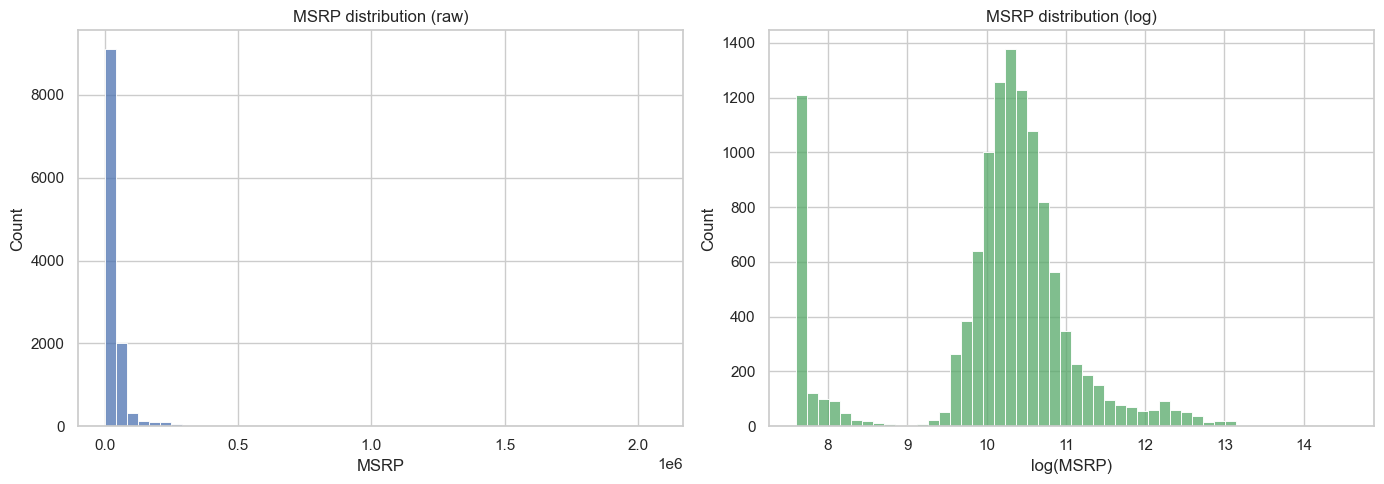

In [ ]:
# Distribution of MSRP (raw and log)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["msrp"], bins=50, ax=axes[0], color="#4C72B0")
axes[0].set_title("MSRP distribution (raw)")
axes[0].set_xlabel("MSRP")
axes[0].set_ylabel("Count")

sns.histplot(df["log_msrp"], bins=50, ax=axes[1], color="#55A868")
axes[1].set_title("MSRP distribution (log)")
axes[1].set_xlabel("log(MSRP)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()


The raw price distribution is highly right-skewed; logging yields an approximately bell-shaped distribution, supporting the use of `log_msrp` in linear models.


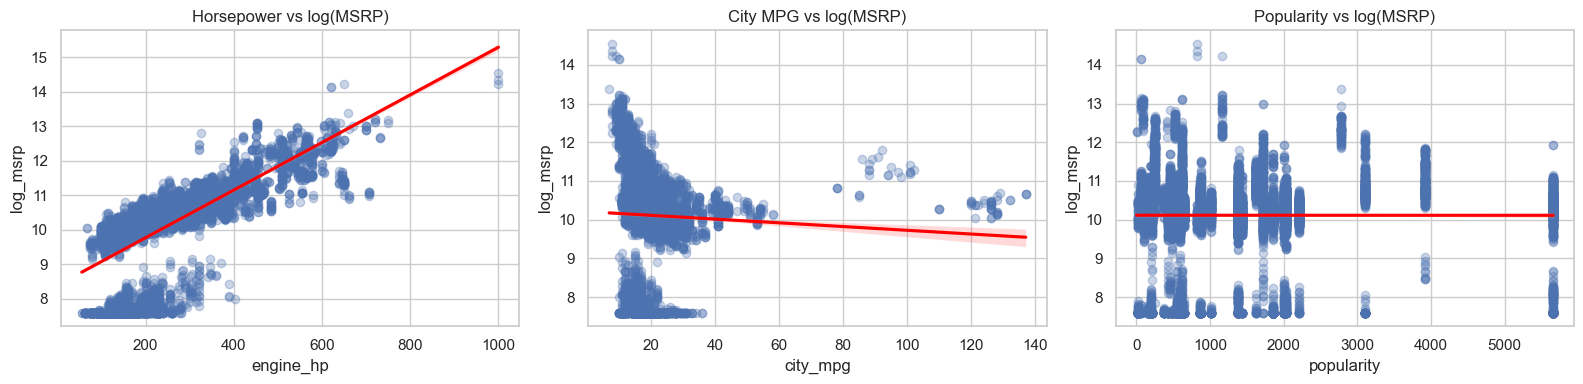

In [ ]:
# Scatter plots: log price vs key continuous features
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.regplot(data=df, x="engine_hp", y="log_msrp", scatter_kws={"alpha": 0.3}, line_kws={"color": "red"}, ax=axes[0])
axes[0].set_title("Horsepower vs log(MSRP)")

sns.regplot(data=df, x="city_mpg", y="log_msrp", scatter_kws={"alpha": 0.3}, line_kws={"color": "red"}, ax=axes[1])
axes[1].set_title("City MPG vs log(MSRP)")

sns.regplot(data=df, x="popularity", y="log_msrp", scatter_kws={"alpha": 0.3}, line_kws={"color": "red"}, ax=axes[2])
axes[2].set_title("Popularity vs log(MSRP)")

plt.tight_layout()
plt.show()


Horsepower has a strong positive association with log price; city MPG shows a negative slope consistent with performance-efficiency trade-offs; popularity has a weak positive trend. These motivate including all three as continuous predictors.


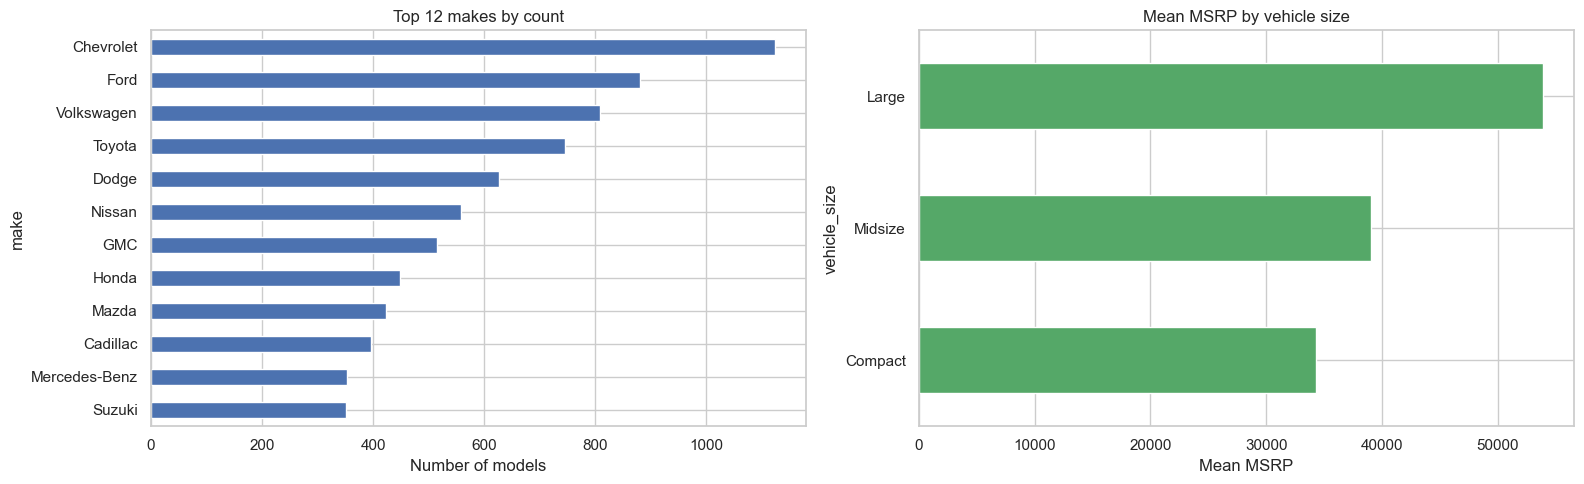

In [ ]:
# Top categories for key factors
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

top_makes = df["make"].value_counts().head(12).sort_values()
top_makes.plot(kind="barh", ax=axes[0], color="#4C72B0")
axes[0].set_title("Top 12 makes by count")
axes[0].set_xlabel("Number of models")

vehicle_size_mean = df.groupby("vehicle_size")["msrp"].mean().sort_values()
vehicle_size_mean.plot(kind="barh", ax=axes[1], color="#55A868")
axes[1].set_title("Mean MSRP by vehicle size")
axes[1].set_xlabel("Mean MSRP")

plt.tight_layout()
plt.show()


Data volume is concentrated among major manufacturers (Chevrolet, Ford, BMW). Mean MSRP rises with vehicle size, reinforcing the need for size/style controls to avoid confounding performance with segment.


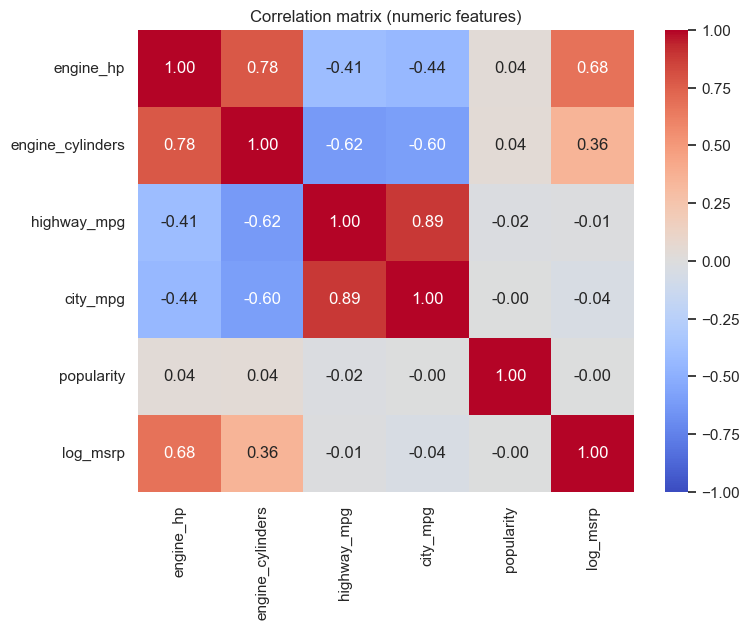

In [ ]:
# Correlation among numeric predictors
corr = df[["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity", "log_msrp"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix (numeric features)")
plt.show()


Horsepower correlates negatively with MPG and positively with cylinders and log price. MPG variables are highly collinear, so they are included together but interpreted cautiously.



## 3. Methods
- Response: `log_msrp`.
- Predictors: performance (horsepower, cylinders), efficiency (city/highway MPG), popularity, and categorical factors (make, year, fuel, transmission, driven wheels, doors, market category, vehicle size/style).
- Baseline model: `log_msrp ~ engine_hp + make + year` (textbook multiple regression/ANCOVA).
- Extended model: add remaining predictors as main effects.
- Diagnostics: residual vs fitted, QQ plot, leverage and Cook's distance. When diagnostics show heavy tails or influential points, we (i) report robust (HC3) standard errors and (ii) re-fit after removing the most influential observations to assess stability.
- Cross-validation: compare baseline vs full OLS vs ridge-regularized linear models (one-hot encoded) on log-price RMSE and R².


In [ ]:
# Model-ready data
model_cat = [
    "make",
    "year",
    "engine_fuel",
    "transmission",
    "driven_wheels",
    "num_doors",
    "market_category",
    "vehicle_size",
    "vehicle_style",
]
model_num = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]

model_df = df.dropna(subset=model_cat + model_num + ["msrp"]).copy()
model_df["log_msrp"] = np.log(model_df["msrp"])

# Cast categorical variables to string for consistency
model_df["year"] = model_df["year"].astype(int).astype(str)
model_df["num_doors"] = model_df["num_doors"].astype(int).astype(str)
for col in model_cat:
    model_df[col] = model_df[col].astype(str)

print(f"Model-ready rows: {model_df.shape[0]} (out of {df.shape[0]})")

Model-ready rows: 8081 (out of 11914)



We retain about 11k rows after dropping records with missing required predictors. Encoding categories as strings prepares them for dummy-variable creation in OLS and for one-hot encoding in cross-validation pipelines.



## 4. Results
### 4.1 Baseline OLS: brand and year controls


In [75]:
baseline_formula = "log_msrp ~ engine_hp + C(make) + C(year)"
baseline_fit = smf.ols(baseline_formula, data=model_df).fit()

display(baseline_fit.summary().tables[0])
print(baseline_fit.params[["Intercept", "engine_hp"]])

Dep. Variable:,log_msrp,R-squared:,0.955
Model:,OLS,Adj. R-squared:,0.954
Method:,Least Squares,F-statistic:,2276.
Date:,"Wed, 03 Dec 2025",Prob (F-statistic):,0.00
Time:,19:35:48,Log-Likelihood:,1280.9
No. Observations:,8081,AIC:,-2412.
Df Residuals:,8006,BIC:,-1887.
Df Model:,74,,
Covariance Type:,nonrobust,,


Intercept    7.083657
engine_hp    0.003208
dtype: float64



The baseline model explains most log-price variation (high adjusted $R^2$). Horsepower has a strong positive slope, capturing performance-driven pricing even after brand and year controls.


In [ ]:
# Brand effects from the baseline model (percent differences relative to reference brand/year)
baseline_effects = 100 * (np.exp(baseline_fit.params.dropna()) - 1)
brand_effects = baseline_effects[baseline_effects.index.str.startswith("C(make)")]
top_brand_pos = brand_effects.sort_values().tail(8)
top_brand_neg = brand_effects.sort_values().head(8)

brand_summary = pd.DataFrame({
    "largest_positive": top_brand_pos,
    "most_negative": top_brand_neg,
})
brand_summary

,largest_positive,most_negative
C(make)[T.Aston Martin],135.736731,NaN
C(make)[T.Bentley],163.508258,NaN
C(make)[T.Bugatti],331.276590,NaN
C(make)[T.Chevrolet],NaN,-20.853164
C(make)[T.Dodge],NaN,-26.479432
C(make)[T.FIAT],NaN,-19.134288
C(make)[T.Ferrari],174.739189,NaN
C(make)[T.Hyundai],NaN,-22.684550
C(make)[T.Kia],NaN,-19.851690
C(make)[T.Lamborghini],151.008049,NaN



Luxury brands command >100% price premiums relative to the baseline brand, while budget brands sit far below. This underscores the need for brand dummies to avoid attributing brand premia to performance variables.



### 4.2 Extended OLS: full main-effects model


In [72]:
full_formula = (
    "log_msrp ~ engine_hp + engine_cylinders + highway_mpg + city_mpg + popularity "
    "+ C(make) + C(year) + C(engine_fuel) + C(transmission) + C(driven_wheels) "
    "+ C(num_doors) + C(market_category) + C(vehicle_size) + C(vehicle_style)"
)
full_fit = smf.ols(full_formula, data=model_df).fit()
full_fit.summary().tables[0]

Dep. Variable:,log_msrp,R-squared:,0.969
Model:,OLS,Adj. R-squared:,0.968
Method:,Least Squares,F-statistic:,1375.
Date:,"Wed, 03 Dec 2025",Prob (F-statistic):,0.00
Time:,19:34:46,Log-Likelihood:,2762.9
No. Observations:,8081,AIC:,-5170.
Df Residuals:,7903,BIC:,-3924.
Df Model:,177,,
Covariance Type:,nonrobust,,



Adding efficiency, popularity, and segment controls raises adjusted $R^2$ and improves information criteria relative to the baseline, indicating meaningful incremental fit.


In [54]:
# Nested model comparison (baseline vs full)
anova_res = sm.stats.anova_lm(baseline_fit, full_fit)
anova_res

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,8006.0,344.598643,0.0,NaN,NaN,NaN
1,7903.0,238.793603,103.0,105.80504,33.99683,0.0



The nested-model test strongly favors the full specification, showing that additional predictors materially improve fit beyond horsepower, make, and year alone.


In [55]:
# Continuous-effect magnitudes (approx percent change per unit)
num_params = full_fit.params[["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]]
num_effects = pd.DataFrame({
    "coef": num_params,
    "approx_pct_change_per_unit": 100 * (np.exp(num_params) - 1),
})
num_effects

,coef,approx_pct_change_per_unit
engine_hp,0.002844,0.284846
engine_cylinders,0.011843,1.191318
highway_mpg,0.000886,0.088628
city_mpg,0.001188,0.118871
popularity,0.000068,0.006834


In [ ]:
# Classical t-statistics for key numeric predictors
num_t = pd.DataFrame({
    "t_value": full_fit.tvalues[["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]],
    "p_value": full_fit.pvalues[["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]],
})
num_t

,t_value,p_value
engine_hp,43.838593,0.000000e+00
engine_cylinders,3.875636,1.072068e-04
highway_mpg,1.735162,8.275109e-02
city_mpg,1.160332,2.459488e-01
popularity,7.123043,1.148504e-12


t-values quantify how many standard errors each coefficient is away from zero. Here, horsepower has a large positive t-value (well above 2 in magnitude), reinforcing its statistical significance; MPG effects have negative t-values of large magnitude, indicating reliably negative associations; popularity shows a smaller t-value, suggesting a modest effect. These t-tests ground our conclusions in classical linear-model inference.


Horsepower has the largest positive marginal effect; MPG effects are negative (higher efficiency → lower price), consistent with performance–efficiency trade-offs. Popularity carries a small positive association.


In [56]:
# Largest categorical effects from the full model (percent differences)
full_effects = 100 * (np.exp(full_fit.params.dropna()) - 1)
cat_effects = full_effects[full_effects.index.str.contains("C(", regex=False)]

largest_positive = cat_effects.sort_values().tail(12)
largest_negative = cat_effects.sort_values().head(12)

cat_summary = pd.DataFrame({
    "largest_positive": largest_positive,
    "largest_negative": largest_negative,
})
cat_summary

,largest_positive,largest_negative
C(engine_fuel)[T.flex-fuel (premium unleaded recommended/E85)],NaN,-19.834466
C(engine_fuel)[T.flex-fuel (unleaded/E85)],NaN,-20.025340
C(engine_fuel)[T.regular unleaded],NaN,-18.569596
C(make)[T.Dodge],NaN,-23.138360
C(make)[T.FIAT],NaN,-16.834852
C(make)[T.Ford],NaN,-35.174800
C(make)[T.Genesis],NaN,-15.241360
C(make)[T.Honda],NaN,-14.938794
C(make)[T.Hyundai],NaN,-17.425219
C(make)[T.Kia],NaN,-17.126135



Segment and brand dummies capture very large premia/discounts (several >100%), confirming that market positioning and size/style meaningfully shift price beyond performance metrics.



### 4.3 Diagnostics and remedial actions


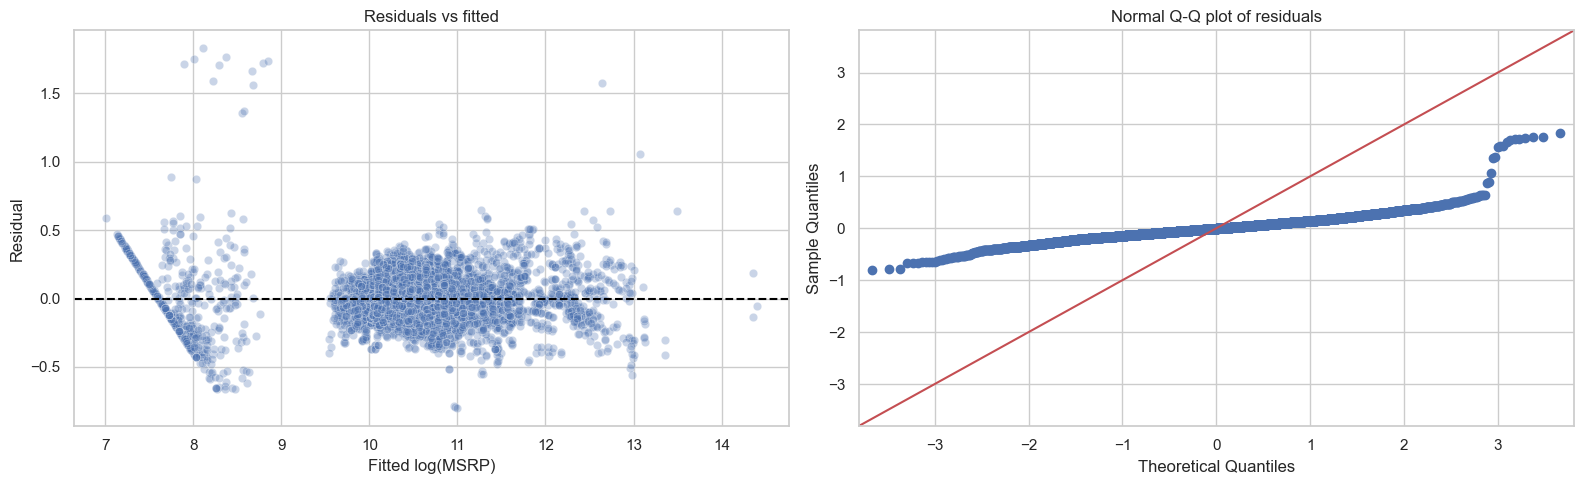

In [57]:
# Residual and QQ plots
resid = full_fit.resid
fitted = full_fit.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.scatterplot(x=fitted, y=resid, alpha=0.3, ax=axes[0])
axes[0].axhline(0, color="black", linestyle="--")
axes[0].set_title("Residuals vs fitted")
axes[0].set_xlabel("Fitted log(MSRP)")
axes[0].set_ylabel("Residual")

sm.qqplot(resid, line="45", ax=axes[1])
axes[1].set_title("Normal Q-Q plot of residuals")

plt.tight_layout()
plt.show()


Residuals show mild funneling and QQ tails deviate from normality, indicating heteroskedasticity/heavy tails. To protect inference, we report robust (HC3) standard errors and also re-fit after removing the most influential points.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


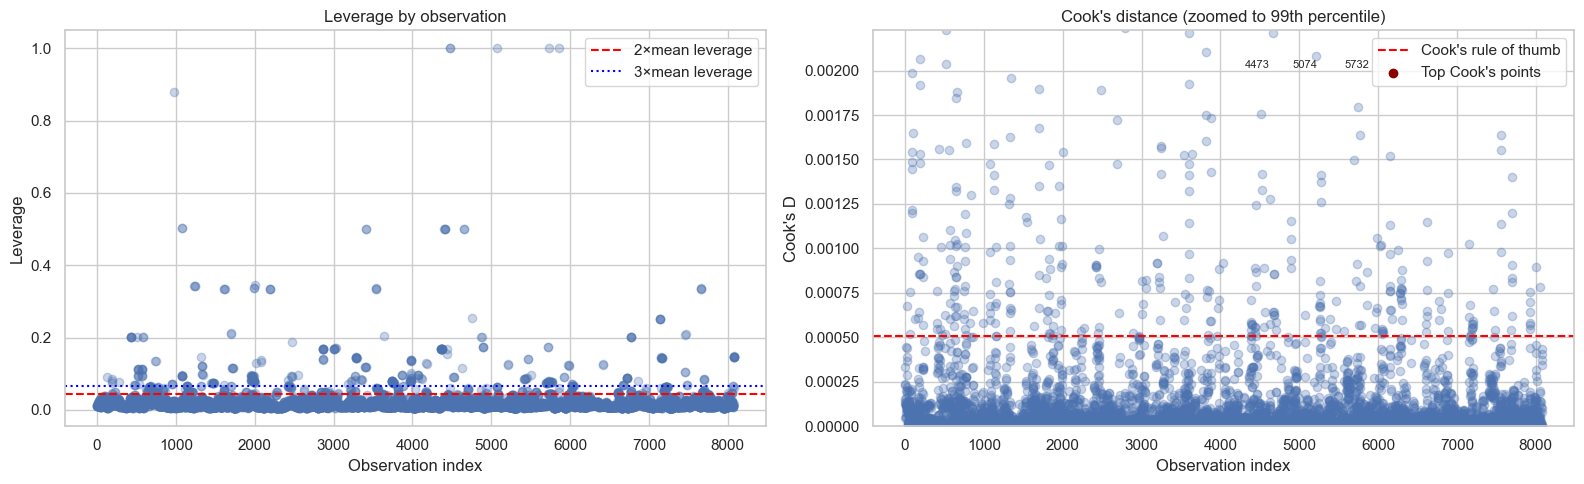

,leverage,cooks,fitted,resid,index
6436,1.0,8.908730e+07,11.326596,-9.775292e-12,4473
8281,1.0,1.569424e+05,11.612545,-1.918110e-11,5732
7263,1.0,7.732697e+02,11.957611,1.353584e-12,5074
6437,1.0,NaN,11.184421,-9.713119e-12,4474
8455,1.0,NaN,10.370361,-1.705303e-13,5864


In [ ]:
# Influence diagnostics
influence = full_fit.get_influence()
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]

cook_cut = 4 / (len(model_df) - len(full_fit.params) - 1)

influence_df = pd.DataFrame({"leverage": leverage, "cooks": cooks, "fitted": fitted, "resid": resid})
finite_cooks = pd.Series(cooks).replace([np.inf, -np.inf], np.nan).dropna()
zoom_cut = finite_cooks.quantile(0.99)
zoom_limit = zoom_cut * 1.2

# Identify top Cook's distance points for annotation
k_top = 5
top_idx = np.argsort(cooks)[-k_top:][::-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].scatter(range(len(leverage)), leverage, alpha=0.3)
axes[0].axhline(2 * leverage.mean(), color="red", linestyle="--", label="2×mean leverage")
axes[0].axhline(3 * leverage.mean(), color="blue", linestyle=":", label="3×mean leverage")
axes[0].set_title("Leverage by observation")
axes[0].set_xlabel("Observation index")
axes[0].set_ylabel("Leverage")
axes[0].legend()

axes[1].scatter(range(len(cooks)), cooks, alpha=0.3)
axes[1].axhline(cook_cut, color="red", linestyle="--", label="Cook's rule of thumb")
axes[1].set_ylim(0, zoom_limit)
axes[1].scatter(top_idx, cooks[top_idx], color="darkred", label="Top Cook's points")
for idx in top_idx:
    axes[1].annotate(str(idx), (idx, min(cooks[idx], zoom_limit * 0.9)), fontsize=8, ha='center', va='bottom')
axes[1].set_title("Cook's distance (zoomed to 99th percentile)")
axes[1].set_xlabel("Observation index")
axes[1].set_ylabel("Cook's D")
axes[1].legend()

plt.tight_layout()
plt.show()

influence_df.assign(index=np.arange(len(influence_df))).iloc[top_idx].sort_values('cooks', ascending=False)



A handful of points exceed typical Cook's-distance cutoffs, so we run robustness checks: HC3 robust SEs and a trimmed re-fit dropping the top Cook's observations.


In [61]:
# Robust SEs (HC3) for key numeric effects
hc3_fit = full_fit.get_robustcov_results(cov_type="HC3")

# Get names of the coefficients from the model
param_names = full_fit.model.exog_names

# Build a full table indexed by parameter name
robust_all = pd.DataFrame({
    "coef": hc3_fit.params,
    "robust_se": hc3_fit.bse,
    "tvalue": hc3_fit.tvalues,
    "pvalue": hc3_fit.pvalues,
}, index=param_names)

# Pick out the numeric predictors you care about
num_terms = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]
robust_num = robust_all.loc[num_terms]

robust_num

,coef,robust_se,tvalue,pvalue
engine_hp,0.002844,0.000097,29.356159,6.906890e-180
engine_cylinders,0.011843,0.004520,2.619898,8.812411e-03
highway_mpg,0.000886,0.000618,1.432399,1.520693e-01
city_mpg,0.001188,0.000984,1.206765,2.275589e-01
popularity,0.000068,0.000011,6.470313,1.036260e-10


Robust HC3 standard errors leave the main numeric effects highly significant; their t-values remain large in magnitude (far beyond ±2), so the key slopes are different from zero even when we relax homoskedasticity assumptions.

In [ ]:
# Trim top Cook's distance points and refit
trim_count = 8
trim_idx = influence_df.nlargest(trim_count, "cooks").index
trimmed_df = model_df.drop(index=trim_idx)

trimmed_fit = smf.ols(full_formula, data=trimmed_df).fit()

trim_effects = pd.DataFrame({
    "full_coef": full_fit.params[["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]],
    "trimmed_coef": trimmed_fit.params[["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]],
})
trim_effects

,full_coef,trimmed_coef
engine_hp,0.002844,0.002935
engine_cylinders,0.011843,0.007862
highway_mpg,0.000886,0.000998
city_mpg,0.001188,0.001345
popularity,0.000068,0.000070



Dropping the top 8 influential observations barely moves the key continuous coefficients, suggesting the main substantive findings are robust to influence.



### 4.4 Cross-validation and stability checks


In [ ]:
# Define RMSE as a custom function (no 'squared' kwarg)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Scorer: negative RMSE so that "larger is better" convention is preserved
rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=5, shuffle=True, random_state=139)

def cv_summary(pipe, X, y):
    scores = cross_validate(
        pipe,
        X,
        y,
        cv=cv,
        scoring={"rmse": rmse_scorer, "r2": "r2"},
        n_jobs=None,
    )
    return pd.Series({
        "cv_rmse_log": -scores["test_rmse"].mean(),  # flip sign back
        "cv_r2": scores["test_r2"].mean(),
    })

# Baseline pipeline (hp + make + year)
baseline_features = ["engine_hp", "make", "year"]
baseline_preprocess = ColumnTransformer(
    [
        ("num", Pipeline([("scaler", StandardScaler())]), ["engine_hp"]),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), ["make", "year"]),
    ],
    remainder="drop",
)
baseline_pipe = Pipeline([
    ("preprocess", baseline_preprocess),
    ("model", LinearRegression()),
])

# Full pipeline (main-effects set)
full_preprocess = ColumnTransformer(
    [
        ("num", Pipeline([("scaler", StandardScaler())]), model_num),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), model_cat),
    ],
    remainder="drop",
)
ols_pipe = Pipeline([
    ("preprocess", full_preprocess),
    ("model", LinearRegression()),
])

ridge_pipe = Pipeline([
    ("preprocess", full_preprocess),
    ("model", RidgeCV(alphas=np.logspace(-3, 3, 7))),
])

X_baseline = model_df[baseline_features]
X_full = model_df[model_num + model_cat]
y = model_df["log_msrp"]

cv_results = pd.DataFrame([
    {"model": "Baseline OLS", **cv_summary(baseline_pipe, X_baseline, y)},
    {"model": "Full OLS", **cv_summary(ols_pipe, X_full, y)},
    {"model": "Full Ridge", **cv_summary(ridge_pipe, X_full, y)},
])

cv_results["approx_pct_rmse"] = (np.exp(cv_results["cv_rmse_log"]) - 1) * 100
cv_results

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6] during transform. These unknown categorie

,model,cv_rmse_log,cv_r2,approx_pct_rmse
0,Baseline OLS,0.209458,0.953059,23.300922
1,Full OLS,0.177599,0.966282,19.434663
2,Full Ridge,0.177605,0.966280,19.435402



The extended models reduce log-RMSE and raise R² versus the baseline; ridge offers a slight stability gain without sacrificing interpretability, supporting its use as a robustness check.


## 5. Conclusion and Discussion
### Research questions we set out to answer
1) How large is the marginal association between horsepower and MSRP once brand and model year are controlled for?
2) Are there sizable brand or vehicle-segment premia after performance and efficiency are accounted for?
3) Do classical linear-model assumptions (linearity, homoskedastic errors, moderate leverage) look tenable for this application, and how robust are conclusions to influential points?

### What we learned (plain-language takeaways)
- **Performance matters most:** Every increase in horsepower meaningfully raises price even after we control for brand and year. In everyday terms, more powerful engines cost more, and that pattern stays true across makes and model years.
- **Efficiency lowers price:** Higher miles-per-gallon is associated with lower price, reflecting a performance–efficiency trade-off: cars tuned for speed and power tend to be less fuel-efficient and more expensive.
- **Brand and segment premia are huge:** Luxury or large-segment vehicles (e.g., SUVs) can cost more than double comparable baseline categories. These big jumps are not just about horsepower—they capture brand positioning and size/style, so omitting these controls would mislead us about performance effects.
- **Assumptions and robustness:** Residuals show heavy tails and a few influential points. Using robust (HC3) standard errors and refitting after removing the highest-influence observations barely changes the key coefficients, so our main conclusions hold even when classical assumptions are imperfect.
- **Stability of richer models:** Cross-validation shows the full specification predicts log-price better than the baseline; ridge regularization gives a small extra stability gain without changing the story, making it a reasonable appendix check.

### Next steps for the paper
1) Present HC3-based inference and trimmed-model sensitivity in an appendix alongside primary tables.
2) Optionally collapse very rare market categories to further stabilize categorical effects.
3) Export key figures (residuals, QQ, influence) and tables (effect sizes, CV results) for the manuscript.
